# Notebook supporting the manuscript: "*pyet* - A python tool for estimating potential evaporation and accounting for model uncertainty and climate change"
*M.Vremec, October 2022, University of Graz*

*R.Collenteur, eawag, Switzerland*

Data source: ZAMG - https://data.hub.zamg.ac.at

### The supporting Notebook is structured as follows:

1. PE assessment using a variety of different methods (with station data KNMI)
    - Makkink vs PM vs Oudin vs Priestley-Taylor vs Hamon vs Hargreaves
2. PE calibration and spatial application (with eobs data)
    - calculate_all
3. Estimating PE under climate change  (with ZAMG data)
    - uncalibrated
    - calibrated on Ambient
    - calibrated on future

## Import packages

In [1]:
# 1. Import needed Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import seaborn as sns

from scipy.optimize import least_squares
import pylab
import matplotlib.dates as mdates

import pyet
from utils import *
pyet.show_versions()

Python version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.21.5
Pandas version: 1.4.4
Pyet version: 1.2.2b


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# edit default values for plots
params = {
    "font.family": "Arial",
    "legend.fontsize": "15",
    "axes.labelsize": "16",
    "xtick.labelsize": "15",
    "ytick.labelsize": "15",
    "xtick.direction": "in",
    "ytick.direction": "in",}
pylab.rcParams.update(params)

# 0. Benchmarking PET methods

In [74]:
df_danlu = pd.read_excel("data//example_0//df_Danlu.xlsx", index_col="daily", 
                         parse_dates=True).iloc[:50, :]

In [5]:
lat = -0.6095
elevation = 48

In [6]:
rs = pyet.calc_rad_sol_in(df_danlu["n"], lat, as1=0.23, bs1=0.5, nn=None)
tmax = df_danlu["Tmax"]
tmin = df_danlu["Tmin"]
tmean = (tmax+tmin)/2
rhmax = df_danlu["RHmax"]
rhmin = df_danlu["RHmin"]
uz = df_danlu["uz"]
z0=0.001
z=10
#u2 = wind * 4.87/np.log(67.8*z0-5.42) 
wind_penman = uz * np.log(2/z0) / np.log(z/z0)
z0 = 0.02
wind_fao56 = uz * 4.87 / np.log(67.8*z-5.42)
rh = (rhmax+rhmin)/2
lambda1=pyet.calc_lambda(tmean=tmean)
lambda0 = 2.45
lambda_corr = lambda1 / lambda0

In [7]:
# Benchmarking against R-Evapotranspiration package
df_pyet_danlu = pyet.calculate_all(tmean, wind_fao56, rs, elevation, lat, tmax, tmin, rh, rhmax=rhmax, rhmin=rhmin)

### Test Penman

In [8]:
#%%timeit
pyet_penman = pyet.penman(tmean, wind_penman, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh, 
                          rhmax=rhmax, rhmin=rhmin, aw=1, bw=0.526, albedo=0.08) * lambda_corr

In [9]:
np.array_equal(pyet_penman.iloc[:10].round(1).values, df_danlu["Penman"].iloc[:10].round(1).values)

True

### Test FAO-56, ASCE, Penman-Monteith

In [10]:
np.array_equal(df_pyet_danlu["FAO-56"].iloc[:10].round(1).values, df_danlu["PM"].iloc[:10].round(1).values)

True

In [11]:
pyet_pmasce = pyet.pm_asce(tmean, wind_fao56, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh, 
                          rhmax=rhmax, rhmin=rhmin)

In [12]:
np.array_equal(pyet_pmasce.iloc[:10].round(1).values, df_danlu["PM"].iloc[:10].round(1).values)

True

In [13]:
pyet_pm = pyet.pm(tmean, wind_fao56, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh, 
                  rhmax=rhmax, rhmin=rhmin) * lambda_corr

In [14]:
np.array_equal(pyet_pm.iloc[:10].round(1).values, df_danlu["PM"].iloc[:10].round(1).values)

True

In [15]:
df_danlu["PM"].iloc[:10].round(1).values

array([5.1, 5. , 5. , 5.2, 5.9, 8.8, 6.3, 7.8, 8. , 5.7])

### Test Makkink

In [16]:
pyet_makk = (pyet.makkink(tmean, rs=rs, elevation=elevation, k=0.61)  * lambda_corr - 0.12) 

In [17]:
np.array_equal(pyet_makk.iloc[:10].round(1).values, df_danlu["Makkink"].iloc[:10].round(1).values)

True

### Test Priestley-Taylor

In [18]:
np.array_equal((df_pyet_danlu["Priestley-Taylor"]*lambda_corr).iloc[:10].round(1).values, df_danlu["PT"].iloc[:10].round(1).values)

True

### Hargreaves

In [19]:
pyet_hargreaves = pyet.hargreaves(tmean, tmax, tmin, lat, method=1)

In [20]:
np.array_equal(pyet_hargreaves.iloc[:10].round(1).values, df_danlu["Har"].iloc[:10].round(1).values)

True

### Test Hamon

In [21]:
pyet_hamon = pyet.hamon(tmean, lat=lat, n=df_danlu["n"], tmax=tmax, tmin=tmin, method=3)

In [22]:
np.array_equal(pyet_hamon.iloc[:10].round(1).values, df_danlu["Hamon"].iloc[:10].round(1).values)

True

### Blaney Criddle

In [23]:
pyet_bc = pyet.blaney_criddle(tmean, lat, rhmin=rhmin, wind=wind_fao56, method=2, n=df_danlu["n"], clip_zero=False)

In [24]:
np.array_equal(pyet_bc.iloc[:10].round(1).values, df_danlu["BC"].iloc[:10].round(1).values)

True

### Romanenko

In [25]:
np.array_equal(df_pyet_danlu["Romanenko"].iloc[:10].round(1).values, df_danlu["Romanenko"].iloc[:10].round(1).values)

True

### McGuinness-Bordne

In [26]:
np.array_equal((df_pyet_danlu["Mcguinness-Bordne"]*lambda_corr).iloc[:10].round(1).values, 
               df_danlu["McG"].iloc[:10].round(1).values)

True

### Jensen-Haise

In [27]:
np.array_equal((df_pyet_danlu["Jensen-Haise"]*lambda_corr).iloc[:10].round(1).values, 
               df_danlu["JH"].iloc[:10].round(1).values)

True

### Linacre

In [28]:
pyet_linacre = pyet.linacre(tmean, elevation, lat, tdew=df_danlu["Tdew"])

In [29]:
np.array_equal(pyet_linacre.iloc[:10].round(1).values, 
               df_danlu["Linacre"].iloc[:10].round(1).values)

True

### Abtew

In [30]:
pyet_abtew = pyet.abtew(tmean, rs, k=0.52) * lambda_corr

In [31]:
np.array_equal(pyet_abtew.iloc[:10].round(1).values, 
               df_danlu["Abtew"].iloc[:10].round(1).values)

True

### Turc

In [32]:
np.array_equal(df_pyet_danlu["Turc"].iloc[:10].round(1).values, 
               df_danlu["Turc"].iloc[:10].round(1).values)

True

### Benchmarking against McMahon et al. 2016

In [33]:
# Benchmarking against McMahon et al. 2016
# Makkink # Based on example S19.91, p 80 McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
rs = pd.Series([17.194], index=pd.DatetimeIndex(["1980-07-20"]))
elevation = 546
mcm_mak = [2.3928, (pyet.makkink(tmean, rs, elevation=elevation, k=0.61)) -0.12] # correction for different formula in McMahon_2013
# Blaney Criddle # Based on example S19.93, McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
rhmin = pd.Series([25], index=pd.DatetimeIndex(["1980-07-20"]))
wind = pd.Series([0.5903], index=pd.DatetimeIndex(["1980-07-20"]))
n = pd.Series([10.7], index=pd.DatetimeIndex(["1980-07-20"]))
py = pd.Series([0.2436], index=pd.DatetimeIndex(["1980-07-20"]))
lat = -23.7951 * np.pi / 180
mcm_bc = [3.1426, pyet.blaney_criddle(tmean, lat, wind=wind, n=n, rhmin=rhmin, py=py, method=2)]
# Based on example S19.99, McMahon_etal_2013 # Based on example S19.99, McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
rhmean = pd.Series([48], index=pd.DatetimeIndex(["1980-07-20"]))
rs = pd.Series([17.194], index=pd.DatetimeIndex(["1980-07-20"]))
mcm_turc = [pyet.turc(tmean, rs, rhmean, k=0.32), 2.6727]
# Based on example S19.101, McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
tmax = pd.Series([21], index=pd.DatetimeIndex(["1980-07-20"]))
tmin = pd.Series([2], index=pd.DatetimeIndex(["1980-07-20"]))
lat = -23.7951 * np.pi / 180
mcm_har = [4.1129, pyet.hargreaves(tmean, tmax, tmin, lat, method=1)]

# Based on example S19.109, McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
rn = pd.Series([8.6401], index=pd.DatetimeIndex(["1980-07-20"]))
elevation = 546
mcm_pt = [2.6083, pyet.priestley_taylor(tmean, rn=rn, elevation=elevation, alpha=1.26)]

In [34]:
# Based on example 5.1, P89 Schrodter 1985
tmean = pd.Series([17.3], index=pd.DatetimeIndex(["1980-07-20"]))
lat = 50 * np.pi / 180
sch_bc = [3.9, pyet.blaney_criddle(tmean, lat, method=0)]
# Based on example 5.2, P95 Schrodter 1985
tmean = pd.Series([21.5], index=pd.DatetimeIndex(["1980-07-20"]))
ea = pd.Series([1.19], index=pd.DatetimeIndex(["1980-07-20"]))
e0 = pyet.calc_e0(tmean)
rh = ea / e0 * 100
sch_haude = [3.6, pyet.haude(tmean, rh=rh, k=0.26 / 0.35)]

In [35]:
# Benchmarking against FAO-56
# Hargreasves # Based on example S19.46,p 78 TestFAO56
tmax = pd.Series([26.6], index=pd.DatetimeIndex(["2015-07-15"]))
tmin = pd.Series([14.8], index=pd.DatetimeIndex(["2015-07-15"]))
tmean = (tmax + tmin) / 2
lat = 45.72 * np.pi / 180
fao_har = [5.0, pyet.hargreaves(tmean, tmax, tmin, lat)]

# Based on Example 18, p. 72 FAO.
wind = pd.Series([2.078], index=pd.DatetimeIndex(["2015-07-06"]))
tmax = pd.Series([21.5], index=pd.DatetimeIndex(["2015-07-06"]))
tmin = pd.Series([12.3], index=pd.DatetimeIndex(["2015-07-06"]))
tmean = (tmax + tmin) / 2
rhmax = pd.Series([84], index=pd.DatetimeIndex(["2015-07-06"]))
rhmin = pd.Series([63], index=pd.DatetimeIndex(["2015-07-06"]))
rs = pd.Series([22.07], index=pd.DatetimeIndex(["2015-07-06"]))
n = 9.25
nn = 16.1
elevation = 100
lat = 50.80 * np.pi / 180
fao_56 = [3.9, pyet.pm_fao56(tmean, wind, elevation=elevation, lat=lat, rs=rs, tmax=tmax, tmin=tmin, rhmax=rhmax,
                            rhmin=rhmin, n=n, nn=nn)]

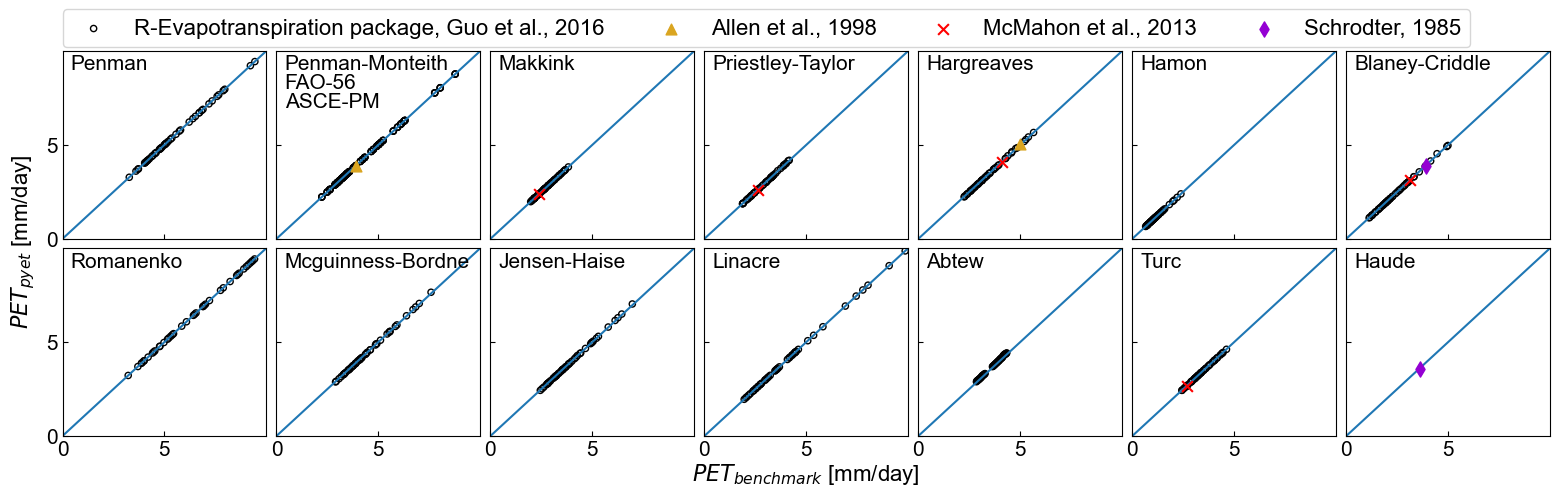

In [75]:
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns
cm1 = 1 / 2.54  # centimeters in inches
fs = 15
ms1 = 20
ms2 = 60

fig,axs=plt.subplots(ncols=7, nrows=2, figsize=(figw_2c,5))
axs[0,0].scatter(df_danlu["Penman"], pyet_penman, c="None", marker="o", s=20, edgecolors="k")
axs[0,0].text(0.04, 0.9, "Penman", transform=axs[0, 0].transAxes, fontsize=fs)

axs[0,1].scatter(df_danlu["PM"], df_pyet_danlu["FAO-56"], c="None", marker="o", s=20, edgecolors="k")
axs[0,1].text(0.04, 0.8, "FAO-56", transform=axs[0, 1].transAxes, fontsize=fs)
axs[0,1].scatter(fao_56[0], fao_56[1], c="goldenrod", marker="^", s=ms2, zorder=10)

axs[0,1].scatter(df_danlu["PM"], pyet_pmasce, c="None", marker="o", s=20, edgecolors="k")
axs[0,1].text(0.04, 0.7, "ASCE-PM", transform=axs[0, 1].transAxes, fontsize=fs)

axs[0,1].scatter(df_danlu["PM"], pyet_pm, c="None", marker="o", s=20, edgecolors="k")
axs[0,1].text(0.04, 0.9, "Penman-Monteith", transform=axs[0, 1].transAxes, fontsize=fs)

axs[0,2].scatter(df_danlu["Makkink"], pyet_makk, c="None", marker="o", s=20, edgecolors="k")
axs[0,2].text(0.04, 0.9, "Makkink", transform=axs[0, 2].transAxes, fontsize=fs)
axs[0,2].scatter(mcm_mak[0], mcm_mak[1], c="red", marker="x", s=ms2, zorder=10)

axs[0,3].scatter(df_danlu["PT"], df_pyet_danlu["Priestley-Taylor"], c="None", marker="o", s=20, edgecolors="k")
axs[0,3].text(0.04, 0.9, "Priestley-Taylor", transform=axs[0, 3].transAxes, fontsize=fs)
axs[0,3].scatter(mcm_pt[0], mcm_pt[1], c="red", marker="x", s=ms2, zorder=10)

p1=axs[0,4].scatter(df_danlu["Har"], pyet_hargreaves, c="None", marker="o", s=20, edgecolors="k")
axs[0,4].text(0.04, 0.9, "Hargreaves", transform=axs[0, 4].transAxes, fontsize=fs)
p2=axs[0,4].scatter(fao_har[0], fao_har[1], c="goldenrod", marker="^", s=ms2, zorder=10)
p3=axs[0,4].scatter(mcm_har[0], mcm_har[1], c="red", marker="x", s=ms2, zorder=10)

axs[0,5].scatter(df_danlu["Hamon"], pyet_hamon, c="None", marker="o", s=20, edgecolors="k")
axs[0,5].text(0.04, 0.9, "Hamon", transform=axs[0, 5].transAxes, fontsize=fs)

axs[0, 6].scatter(df_danlu["BC"], pyet_bc, c="None", marker="o", s=20, edgecolors="k")
axs[0,6].text(0.04, 0.9, "Blaney-Criddle", transform=axs[0, 6].transAxes, fontsize=fs)
axs[0,6].scatter(mcm_bc[0], mcm_bc[1], c="red", marker="x", s=ms2, zorder=10)
p4=axs[0,6].scatter(sch_bc[0], sch_bc[1], c="darkviolet", marker="d", s=ms2, zorder=10)


axs[1,0].scatter(df_danlu["Romanenko"], df_pyet_danlu["Romanenko"], c="None", marker="o", s=20, edgecolors="k")
axs[1,0].text(0.04, 0.9, "Romanenko", transform=axs[1, 0].transAxes, fontsize=fs)

axs[1,1].scatter(df_danlu["McG"], df_pyet_danlu["Mcguinness-Bordne"], c="None", marker="o", s=20, edgecolors="k")
axs[1,1].text(0.04, 0.9, "Mcguinness-Bordne", transform=axs[1, 1].transAxes, fontsize=fs)

axs[1,2].scatter(df_danlu["JH"], df_pyet_danlu["Jensen-Haise"], c="None", marker="o", s=20, edgecolors="k")
axs[1,2].text(0.04, 0.9, "Jensen-Haise", transform=axs[1, 2].transAxes, fontsize=fs)

axs[1,3].scatter(df_danlu["Linacre"], pyet_linacre, c="None", marker="o", s=20, edgecolors="k")
axs[1,3].text(0.04, 0.9, "Linacre", transform=axs[1, 3].transAxes, fontsize=fs)

axs[1,4].scatter(df_danlu["Abtew"], df_pyet_danlu["Abtew"], c="None", marker="o", s=20, edgecolors="k")
axs[1,4].text(0.04, 0.9, "Abtew", transform=axs[1, 4].transAxes, fontsize=fs)

axs[1,5].scatter(df_danlu["Turc"], df_pyet_danlu["Turc"], c="None", marker="o", s=20, edgecolors="k")
axs[1,5].text(0.04, 0.9, "Turc", transform=axs[1, 5].transAxes, fontsize=fs)
axs[1,5].scatter(mcm_turc[0], mcm_turc[1], c="red", marker="x", s=ms2, zorder=10)

axs[1,6].text(0.04, 0.9, "Haude", transform=axs[1, 6].transAxes, fontsize=fs)
axs[1,6].scatter(sch_haude[0], sch_haude[1], c="darkviolet", marker="d", s=ms2, zorder=10)

for i in (0,1,2,3,4,5,6):
    axs[0,i].set_xticklabels([]) 
    for j in (0, 1):
        axs[j,i].set_xlim(0,10)
        axs[j,i].set_ylim(0,10)
        axs[j,i].plot([0, 10], [0, 10])
        axs[j,i].set_xticks([0, 5])
        axs[j,i].set_yticks([0, 5])
        axs[j,i].set_yticklabels([])
        axs[j,0].set_yticklabels([0, 5])

axs[0,i].set_yticklabels([]) 

axs[0,0].legend((p1,p2,p3,p4), ("R-Evapotranspiration package, Guo et al., 2016", 
                                "Allen et al., 1998", "McMahon et al., 2013", "Schrodter, 1985"), ncol=4, loc=[0,1.02], fontsize=16)
fig.supxlabel("$PET_{benchmark}$ [mm/day]", x=0.475, fontsize=16)
fig.supylabel("$PET_{pyet}$ [mm/day]", fontsize=16)
fig.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05)
plt.tight_layout()
#fig.savefig("figure0.png", dpi=600, bbox_inches="tight")

# 1. PET estimation using station data.

Potential evaporation is estimated for the town of De Bilt (Netherlands) using data provided by the Royal Netherlands Meteorological Institute (KNMI). The KNMI reference method for estimating potential evaporation is the Makkink method. The example shows PE estimation with \textit{pyet} using 18 different PE methods, a visual comparison between daily, monthly and cumulative PE, and a comparison between the Makkink's PE estimated with \textit{pyet} and Makkink's PE estimated by the KNMI.

Data source: KNMI - https://dataplatform.knmi.nl/

In [37]:
# 2. Reading meteorological data
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

In [38]:
# 3. Determining the necessary input data
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elevation = 4  # define elevation [meters above sea-level]

Now that we have defined the input data, we can estimate potential evaporation with different estimation methods. 

In [39]:
# 4. Estimate potential evaporation (with all available methods) and save the results in a Pandas.DataFrame
pet_df  = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax, tmin, rh)

In [40]:
print((pet_df.sum().max()-pet_df.sum().mean())/pet_df.sum().mean()*100)
print((pet_df.sum().min()-pet_df.sum().mean())/pet_df.sum().mean()*100)

29.495147668845078
-20.04303375169978


We plot the daily, monthly and cumulative sums to compare the different estimation methods, and also benchmark the Makkink bethod to the KNMI estimated PE with Makkink.

Text(0.05, 0.94, '(d)')

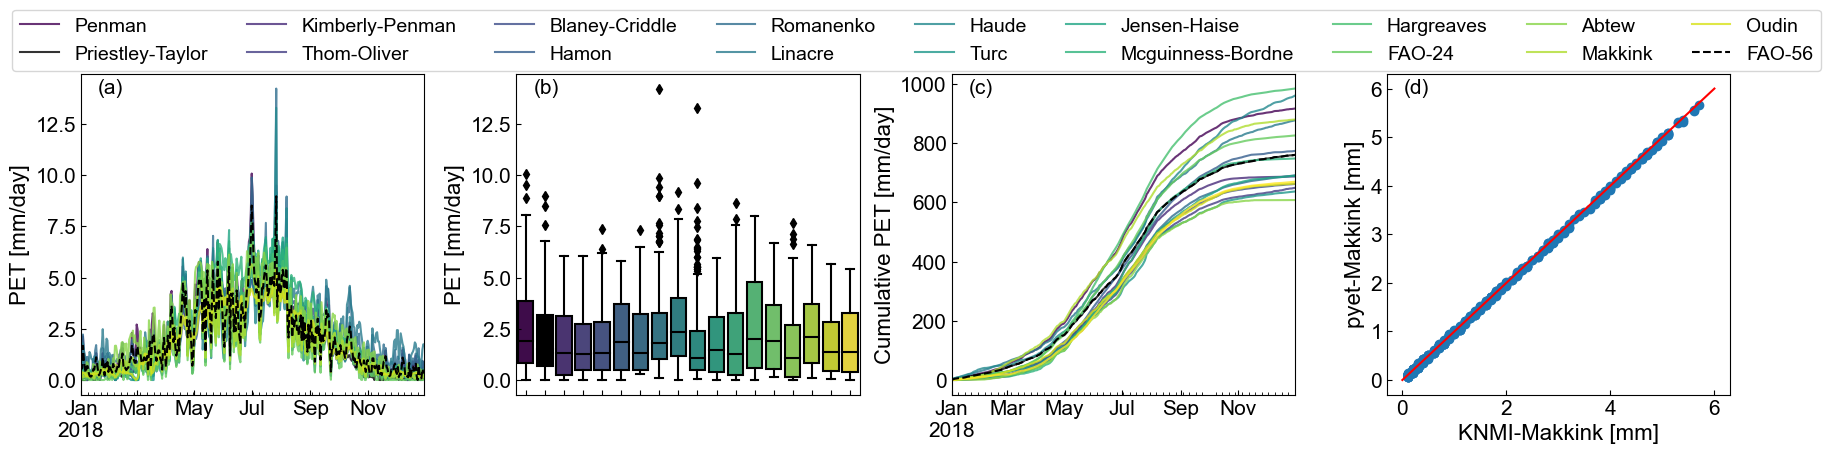

In [41]:
viridis = cm.get_cmap('viridis', len(pet_df.columns))
colors = [viridis(i) for i in range(0, len(pet_df.columns))]
colors[1] = "k"
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns

fig, axs = plt.subplots(figsize=(figw_2c, 4), ncols=4)

pet_df.loc[:, pet_df.columns != "FAO-56"].plot(color=colors, legend=False, ax=axs[0], alpha=0.8)
pet_df.loc[:, "FAO-56"].plot(color=colors[1], linestyle="--", legend=False, ax=axs[0])
axs[0].set_ylabel("PET [mm/day]")

sns.boxplot(pet_df, ax=axs[1], palette=colors)
axs[1].set_ylabel("PET [mm/day]")

pet_df.cumsum().plot(color=colors, legend=False, ax=axs[2], alpha=0.8)
pet_df.loc[:, "FAO-56"].cumsum().plot(color=colors[1], linestyle="--", legend=False, ax=axs[2])
axs[2].set_ylabel("Cumulative PET [mm/day]")

axs[3].scatter(pet_knmi, pet_df["Makkink"])
axs[3].plot([0,6],[0,6], color="red", label="1:1 line")
axs[3].set_xlabel("KNMI-Makkink [mm]");
axs[3].set_ylabel("pyet-Makkink [mm]")

for i in (0,2):
    axs[i].set(xlabel=None)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

axs[1].set_xticklabels([])
plt.tight_layout()
axs[0].legend(loc=(-0.2,1.01), ncol=9, bbox_transform=axs[0].transAxes, fontsize=14)
axs[0].text(0.05,0.94, "(a)", transform=axs[0].transAxes, fontsize=15)
axs[1].text(0.05,0.94, "(b)", transform=axs[1].transAxes, fontsize=15)
axs[2].text(0.05,0.94, "(c)", transform=axs[2].transAxes, fontsize=15)
axs[3].text(0.05,0.94, "(d)", transform=axs[3].transAxes, fontsize=15)
#fig.savefig("figure1.png", dpi=600, bbox_inches="tight")

# 2. Estimate PE for gridded data

In [42]:
# import E-OBS
wind = xr.open_dataset("data//example_0//fg_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4")["fg"]
tmax = xr.open_dataset("data//example_0//tx_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                             latitude=slice(wind.latitude.min(), wind.latitude.max()))["tx"]
tmin = xr.open_dataset("data//example_0//tn_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                             latitude=slice(wind.latitude.min(), wind.latitude.max()))["tn"]
tmean = xr.open_dataset("data//example_0//tg_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                        engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                              latitude=slice(wind.latitude.min(), wind.latitude.max()))["tg"]

In [43]:
rs = xr.open_dataset("data//example_0//qq_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                     engine="netcdf4").sel(lon=slice(wind.longitude.min(), wind.longitude.max()), 
                                           lat=slice(wind.latitude.min(), wind.latitude.max()))
rs = rs.rename_dims({"lon":"longitude", "lat":"latitude"}).rename({"lon":"longitude", "lat":"latitude"}).sel(ensemble=10)["qq"] * 86400 / 1000000

In [44]:
rh = xr.open_dataset("data//example_0//hu_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                     engine="netcdf4").sel(lon=slice(wind.longitude.min(), wind.longitude.max()), 
                                           lat=slice(wind.latitude.min(), wind.latitude.max()))
rh = rh.rename_dims({"lon":"longitude", "lat":"latitude"}).rename({"lon":"longitude", "lat":"latitude"})["hu"]

In [45]:
elevation =  xr.open_dataset("data//example_0//elev_ens_0.25deg_reg_v25.0e.nc", 
                     engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                           latitude=slice(wind.latitude.min(), wind.latitude.max()))["elevation"].fillna(0)

lat = tmean.latitude * np.pi / 180
lat = lat.expand_dims(dim={"longitude":tmean.longitude}, axis=1)

In [46]:
pm_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
makkink = pyet.makkink(tmean, rs, elevation=elevation)
hargreaves = pyet.hargreaves(tmean, tmax, tmin, lat=lat)

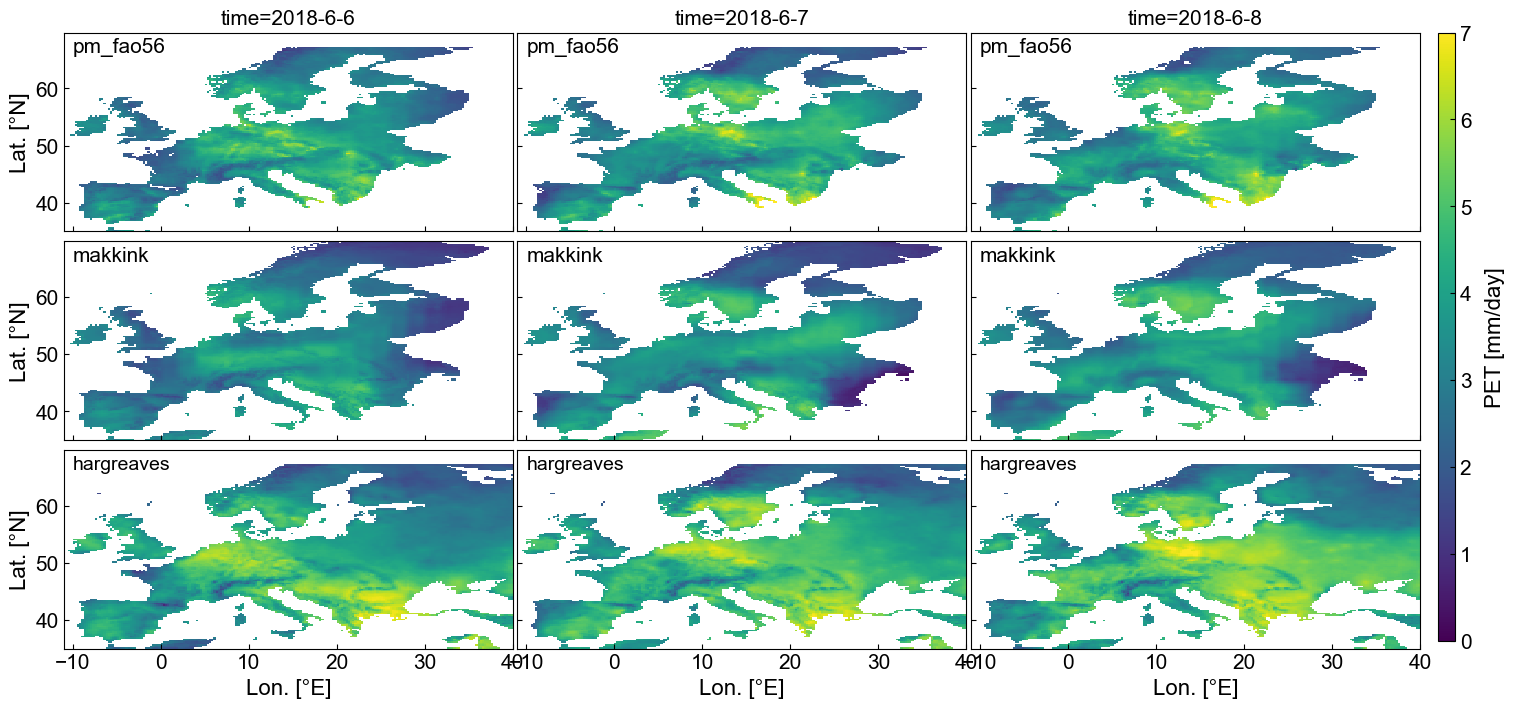

In [47]:
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns
vmax = 7
vmin = 0
day = 120
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(figw_2c, 8), sharey=True, sharex=True)

for date, i in zip(["2018-6-6", "2018-6-7", "2018-6-8"],[0,1,2]):
    pm_fao56.sel(time=date).plot(ax=axs[0,i],vmax=vmax, vmin=vmin, add_colorbar=False)
    axs[0,i].text(0.02, 0.9, "pm_fao56", transform=axs[0,i].transAxes, fontsize=15)

    makkink.sel(time=date).plot(ax=axs[1,i],vmax=vmax, vmin=vmin, add_colorbar=False)
    axs[1,i].text(0.02, 0.9, "makkink", transform=axs[1,i].transAxes, fontsize=15)

    im = hargreaves.sel(time=date).plot(ax=axs[2,i],vmax=vmax, vmin=vmin, add_colorbar=False)
    axs[2,i].text(0.02, 0.9, "hargreaves", transform=axs[2,i].transAxes, fontsize=14)
    

for date, i in zip(["2018-6-6", "2018-6-7", "2018-6-8"],[0,1,2]):
    for j in (0,1,2):
        axs[i, j].set_ylabel("")
        axs[i, j].set_xlabel("")
        axs[i, j].set_title("")
        axs[2,j].set_xlabel("Lon. [°E]")
    axs[i, 0].set_ylabel("Lat. [°N]")
    axs[0,i].set_title("time="+date, fontsize=15)

cbar_ax = fig.add_axes([0.91, 0.12, 0.01, 0.76])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("PET [mm/day]", labelpad=10)
plt.subplots_adjust(hspace=0.05, wspace=0.01)
#fig.savefig("figure2.png", dpi=600, bbox_inches="tight")

# 2. PE calibration and hind/forecasting

In [48]:
#read station data
data_16412 = pd.read_csv('data//example_1//klima_daily.csv', index_col=1, parse_dates=True)
data_16412

,station,strahl,rel,t,tmax,tmin,vv
time,,,,,,,
2000-01-01,16412,300.0,80.0,-2.7,0.5,-5.8,1.0
2000-01-02,16412,250.0,86.0,0.2,2.5,-2.1,1.0
2000-01-03,16412,598.0,86.0,0.6,3.6,-2.4,1.0
2000-01-04,16412,619.0,83.0,-0.5,4.5,-5.5,1.0
2000-01-05,16412,463.0,84.0,-0.1,5.4,-5.5,1.0
...,...,...,...,...,...,...,...
2021-11-07,16412,852.0,74.0,8.5,12.2,4.7,1.6
2021-11-08,16412,553.0,78.0,7.5,10.4,4.5,1.6
2021-11-09,16412,902.0,67.0,7.1,11.7,2.4,2.7


In [49]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100
meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})
time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

lat = 47.077778*np.pi/180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

# Estimate evaporation with four different methods and create a dataframe
pet_df = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax=tmax,
                                tmin=tmin, rh=rh)

## 2.1 Calibrate alternative PE methods to Penman-Monteith

In [50]:
methods = ["oudin", "hargreaves", "mcguinness_bordne", 
           "hamon", "blaney_criddle"]

# Define initial values for calibration for each method
params = [[100, 5], [0.0135], [0.0147],
         [1], [-1.55, 0.96]]

# Define input for each method
input2 = ([tmean, lat], [tmean, tmax, tmin, lat], [tmean, lat],
         [tmean, lat], [tmean, lat])

# Define function to estimate residuals
def simulate(params, method, input1):   
    input1_1 = input1.copy()
    method = getattr(pyet, method)
    for par in params:
        input1_1.append(par)
    return method(*input1_1)
    
def residuals(params, info):
    method, input1, obs = info
    sim = simulate(params, method, input1)
    return sim - obs

In [51]:
obs = pet_df["FAO-56"]
sollutions2 = []
for i in np.arange(0,len(methods)):
    res_1 = least_squares(residuals, params[i], args=[[methods[i], input2[i], obs]])
    sollutions2.append(res_1.x)

In [52]:
pet_df_def = pd.DataFrame()
pet_df_cali = pd.DataFrame()
for i in np.arange(0, len(methods)):
    pet_df_def[methods[i]] = simulate(params[i], methods[i], input2[i])
    pet_df_cali[methods[i]] = simulate(sollutions2[i], methods[i], input2[i])

## 2.2 Hindcasting PE for Graz, Austria

In [55]:
# Estimate for Grazer feld and define input meteorological variables
spartacus = xr.open_dataset("data//example_0//spartacus-daily_19610101T0000_20211231T0000.nc", engine="netcdf4")
spartacus_cali = spartacus.copy()

In [56]:
# Define new input
tmean_spartacus = (spartacus["Tx"] + spartacus["Tn"]) / 2
tmax_spartacus = spartacus["Tx"]
tmin_spartacus = spartacus["Tn"]
lat_spartacus = spartacus.lat * np.pi / 180  # from degrees to radians
input_spartacus = ([tmean_spartacus, lat_spartacus], [tmean_spartacus, tmax_spartacus, tmin_spartacus, lat_spartacus], [tmean_spartacus, lat_spartacus],
         [tmean_spartacus, lat_spartacus], [tmean_spartacus, lat_spartacus])

In [57]:
# Compute PE for Gumpenstein area and add to initial xarray 
for i in np.arange(0,len(methods)):
    spartacus[methods[i]] = simulate(params[i], methods[i], input_spartacus[i])
    spartacus_cali[methods[i]] = simulate(sollutions2[i], methods[i], input_spartacus[i])

In [58]:
df_def = spartacus.to_dataframe().reset_index(level=[1,1]).drop(columns=["y", "Tn", "Tx", "lambert_conformal_conic", "lon", "lat"])
df_cali = spartacus_cali.to_dataframe().reset_index(level=[1,1]).drop(columns=["y", "Tn", "Tx", "lambert_conformal_conic", "lon", "lat"])

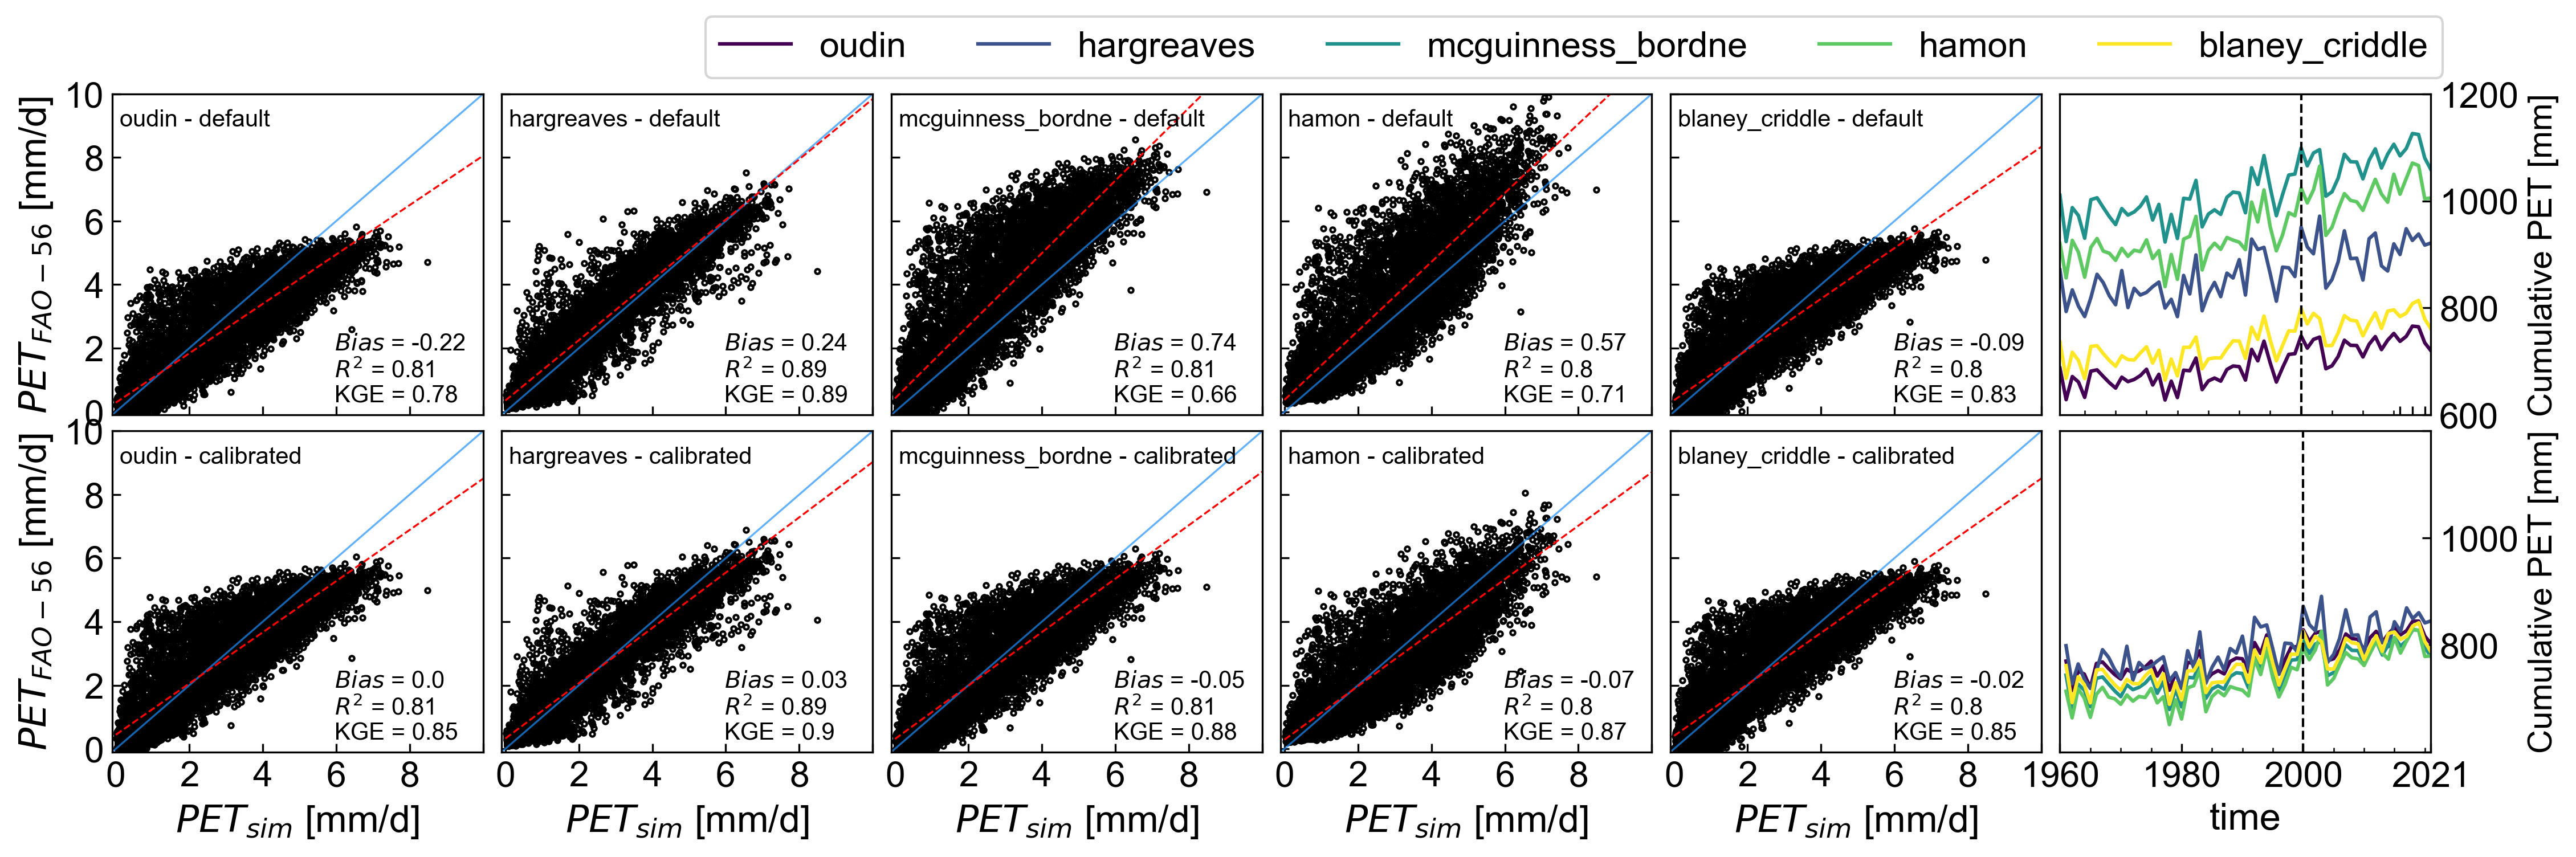

In [60]:
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns

fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(figw_2c, 5), dpi=300)
for i in np.arange(0, len(methods)):
    axs[0,i] = scatter_1(axs[0,i], obs, simulate(params[i], methods[i], input2[i]), label=f"{methods[i]} - default")
    axs[1,i] = scatter_1(axs[1,i], obs, simulate(sollutions2[i], methods[i], input2[i]), label=f"{methods[i]} - calibrated")
    axs[0, i].set_xticklabels([])
    axs[1, i].set_xlabel(r"$PET_{sim}$ [mm/d]")
    axs[1, i].set_xticklabels((0,2,4,6,8,""))
for col in (1, 2, 3, 4):
    axs[0, col].set_yticklabels([])
    axs[1, col].set_yticklabels([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for row in (0, 1):
    axs[row, 0].set_ylabel(r"$PET_{FAO-56}$ [mm/d]")

viridis = cm.get_cmap('viridis', len(df_def.columns))
colors = [viridis(i) for i in range(0, len(df_def.columns))]
df_def.resample("y").sum().plot(ax=axs[0, 5], legend=False, color=colors)
df_cali.resample("y").sum().plot(ax=axs[1, 5], legend=False, color=colors)
axs[0,5].axvline(pd.Timestamp("2000-1-1"), color="k", linestyle="--", lw=1)
axs[1,5].axvline(pd.Timestamp("2000-1-1"), color="k", linestyle="--", lw=1)
#pet_df_def.cumsum().plot(ax=axs[0, 5], legend=False)
#obs.cumsum().plot(ax=axs[0,5], label="pm_fao56$ [mm/d]", color="k", linestyle="--", )
#obs.cumsum().plot(ax=axs[1,5], label="pm_fao56", color="k", linestyle="--", )
#pet_df_cali.cumsum().plot(ax=axs[1, 5], legend=False)
for i in (0,1):
    axs[i,5].yaxis.tick_right()
    axs[i,5].yaxis.set_label_position("right")
    axs[i,5].set_xticks((pd.Timestamp("2016-1-1"), pd.Timestamp("2018-1-1"), pd.Timestamp("2020-1-1")))
    axs[i,5].set_ylim(600, 1200)
    axs[i,5].set_ylabel("Cumulative PET [mm]", fontsize=14)
axs[0,5].set_xticklabels("");
axs[1,5].set_xticks(["1960-1-1", "1980-1-1", "2000-1-1", "2021-1-1"]);
axs[1,5].set_xticklabels(["1960", "1980", "2000", "2021"]);
axs[0,5].set_xlabel("");
plt.subplots_adjust(hspace=0.05, wspace=0.05)
axs[1,5].set_yticklabels(["",800,1000,""])
axs[0,5].legend(loc=(-3.65,1.05), ncol=7, bbox_transform=axs[1,5].transAxes)
#fig.savefig("figure3.png", dpi=600, bbox_inches="tight")

# 2.3 Forecasting for Graz Austria

$$ PET_{CO_2} = f_{CO_2} PET $$

Data source: https://climate-impact-explorer.climateanalytics.org/impacts/?region=AUT&indicator=tasAdjust&scenario=rcp60&subregion=AT.ST&warmingLevel=1.5&temporalAveraging=annual&spatialWeighting=area&compareYear=2030

In [62]:
rcp_temp = pd.read_csv("data//example_0//tasAdjust_AUT_AT.ST_area_annual.csv", skiprows=4, index_col="year").loc["2020":,:]
rcp_temp = rcp_temp.loc[:, ["RCP2.6 median", "RCP4.5 median", "RCP6.0 median", "RCP8.5 median"]]
rcp_temp.columns = ["rcp_26", "rcp_45", "rcp_60", "rcp_85"]

In [63]:
rcp_co2 = pd.DataFrame()
rcp_co2["rcp_26"] = pd.read_csv("data//example_0//co2_conc//RCP3PD_MIDYR_CONC.dat", skiprows=38, delim_whitespace=True, index_col="YEARS").loc["2020":"2100", "CO2"]
rcp_co2["rcp_45"] = pd.read_csv("data//example_0//co2_conc//RCP45_MIDYR_CONC.dat", skiprows=38, delim_whitespace=True, index_col="YEARS").loc["2020":"2100", "CO2"]
rcp_co2["rcp_60"] = pd.read_csv("data//example_0//co2_conc//RCP6_MIDYR_CONC.dat", skiprows=38, delim_whitespace=True, index_col="YEARS").loc["2020":"2100", "CO2"]
rcp_co2["rcp_85"] = pd.read_csv("data//example_0//co2_conc//RCP85_MIDYR_CONC.dat", skiprows=38, delim_whitespace=True, index_col="YEARS").loc["2020":"2100", "CO2"]

In [64]:
# RCP scenario 6.0
co2_600 = 600
pet_300 = pyet.pm(tmean, wind, rs=rs, elevation=elevation, lat=lat, 
                 tmax=tmax, tmin=tmin, rh=rh)
pet_600 = pyet.pm(tmean, wind, rs=rs, elevation=elevation, lat=lat, 
                 tmax=tmax, tmin=tmin, rh=rh, co2=co2_600)

In [65]:
def residuals_co2(S_CO2, PETco2, PETamb, co2):
    fco2 = (1+S_CO2*(co2-300))
    return PETco2 - PETamb * fco2
res1 = least_squares(residuals_co2, [0.02], args=[pet_600, pet_300, 600])
res1.x

array([-0.00015543])

In [66]:
# Define input for each method
inputamb = ([tmean, lat], [tmean, tmax, tmin, lat], [tmean, lat],
         [tmean, lat], [tmean, lat])

In [67]:
def input_rcp(tincrease):
    return ([tmean+tincrease, lat], [tmean+tincrease, tmax+tincrease, tmin+tincrease, lat], [tmean+tincrease, lat],
         [tmean+tincrease, lat], [tmean+tincrease, lat])

In [68]:
dpet_rcp_et = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_et_5th = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_et_95th = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_etco2 = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_etco2_5th = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_etco2_95th = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
for year in rcp_temp.index:
#    print(rcp_temp.loc[year, :], rcp_co2.loc[int(year), :])
    for rcp in ["rcp_26", "rcp_45", "rcp_60", "rcp_85"]:
        df_rcp_et = pd.DataFrame()
        df_rcp_etco2 = pd.DataFrame()
        for i in np.arange(0, len(methods)):
            input1 = input_rcp(rcp_temp.loc[year, rcp])
            df_rcp_et[methods[i]] = simulate(sollutions2[i], methods[i], input1[i])
            df_rcp_etco2[methods[i]] = simulate(sollutions2[i], methods[i], input1[i]) * (1+res1.x*(rcp_co2.loc[year, rcp]-300))
        dpet_rcp_et.loc[year, rcp] = df_rcp_et.resample("y").mean().mean().mean()
        dpet_rcp_et_5th.loc[year, rcp] = df_rcp_et.resample("y").mean().mean().quantile(0.05)
        dpet_rcp_et_95th.loc[year, rcp] = df_rcp_et.resample("y").mean().mean().quantile(0.95)
        dpet_rcp_etco2.loc[year, rcp] = df_rcp_etco2.resample("y").mean().mean().mean()
        dpet_rcp_etco2_5th.loc[year, rcp] = df_rcp_etco2.resample("y").mean().mean().quantile(0.05)
        dpet_rcp_etco2_95th.loc[year, rcp] = df_rcp_etco2.resample("y").mean().mean().quantile(0.95)

In [69]:
dpet_rcp_et = dpet_rcp_et.apply(pd.to_numeric)
dpet_rcp_et_5th = dpet_rcp_et_5th.apply(pd.to_numeric)
dpet_rcp_et_95th = dpet_rcp_et_95th.apply(pd.to_numeric)
dpet_rcp_etco2 = dpet_rcp_etco2.apply(pd.to_numeric)
dpet_rcp_etco2_5th = dpet_rcp_etco2_5th.apply(pd.to_numeric)
dpet_rcp_etco2_95th = dpet_rcp_etco2_95th.apply(pd.to_numeric)

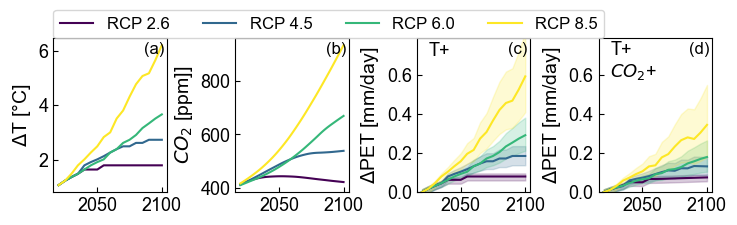

In [76]:
fig, axs = plt.subplots(ncols=4, figsize=(figw_1c,2.))
viridis = cm.get_cmap('viridis', len(rcp_temp.columns))
colors = [viridis(i) for i in range(0, len(rcp_temp.columns))]
for col, rcp, name in zip(colors, rcp_temp.columns, ["RCP 2.6", "RCP 4.5", "RCP 6.0", "RCP 8.5"]):
    axs[2].plot(dpet_rcp_et.loc[:, rcp]-dpet_rcp_et.loc[2020, rcp], c=col);
    axs[2].fill_between(dpet_rcp_et.index, dpet_rcp_et_5th[rcp]-dpet_rcp_et.loc[2020, rcp], 
                        dpet_rcp_et_95th[rcp]-dpet_rcp_et.loc[2020, rcp], color=col, alpha=0.2)
    axs[3].fill_between(dpet_rcp_et.index, dpet_rcp_etco2_5th[rcp]-dpet_rcp_etco2.loc[2020, rcp], 
                        dpet_rcp_etco2_95th[rcp]-dpet_rcp_etco2.loc[2020, rcp], color=col, alpha=0.2)
    axs[3].plot(dpet_rcp_etco2.loc[:, rcp]-dpet_rcp_etco2.loc[2020, rcp], c=col, label=name);
    axs[1].plot(rcp_co2[rcp], c=col)
    axs[0].plot(rcp_temp[rcp], c=col)
axs[0].set_ylabel(r"$\Delta$T [°C]", fontsize=14);
axs[1].set_ylabel("$CO_2$ [ppm]]", fontsize=14);
axs[2].set_ylim(0, 0.79);
axs[3].set_ylim(0, 0.79);
axs[2].set_ylabel("$\Delta$PET [mm/day]", fontsize=14);
axs[3].set_ylabel("$\Delta$PET [mm/day]", fontsize=14);
axs[3].legend(loc=[-4.8,1], ncol=4, fontsize=12);
for i in (0,1,2,3):
    axs[i].tick_params(axis='both', which='major', labelsize=13)
axs[2].text(2025,0.7, "T+", fontsize=13)
axs[3].text(2025,0.59, "T+\n$CO_2$+", fontsize=13)
axs[0].text(0.8, 0.9, "(a)", transform=axs[0].transAxes, fontsize=12)
axs[1].text(0.8, 0.9, "(b)", transform=axs[1].transAxes, fontsize=12)
axs[2].text(0.8, 0.9, "(c)", transform=axs[2].transAxes, fontsize=12)
axs[3].text(0.8, 0.9, "(d)", transform=axs[3].transAxes, fontsize=12)
plt.subplots_adjust(wspace=0.6)
plt.tight_layout()
#fig.savefig("figure5.png", dpi=600, bbox_inches="tight")

# Code example in paper

In [ ]:
# 1. Import needed Python packages
import numpy as np
import pandas as pd

# 2. Reading meteorological data
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

# 3. Determining the necessary input data
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elev = 4  # define elevation [meters above sea-level]

# 4. Estimate PET (all methods) and save the results in a Pandas.DataFrame
pet_df = pyet.calculate_all(tmean, wind, rs, elev, lat, tmax, tmin, rh)
                           
# (4. Estimate potential evaporation - Example with one method)
pyet_makkink = pyet.makkink(tmean, rs, elevation=elev)

# 5. Plot PET 
pet_df.plot()  # daily PET [mm/day]
pet_df.boxplot()  # boxplot PET[mm/day]
pet_df.cumsum().plot()  # cummulative PET [mm]
plt.scatter(pyet_makkink, pet_knmi)  # plot Makkink pyet vs KNMI

In [ ]:
# 2. Reading meteorological data
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

In [ ]:
# 3. Determining the necessary input data
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elevation = 4  # define elevation [meters above sea-level]

Now that we have defined the input data, we can estimate potential evaporation with different estimation methods. 

In [ ]:
# 4. Estimate potential evaporation (with all available methods) and save the results in a Pandas.DataFrame
pet_df  = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax, tmin, rh)

In [ ]:
# 4. Estimate PE and save the results in a xarray.DataArray
pe_pm_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, 
                            lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_makkink = pyet.makkink(tmean, rs, elevation=elevation)
pe_pt = pyet.priestley_taylor(tmean, rs=rs, elevation=elevation, 
                              lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_hamon = pyet.hamon(tmean, lat=lat) 
pe_blaney_criddle = pyet.blaney_criddle(tmean, lat)
pe_hargreaves = pyet.hargreaves(tmean, tmax, tmin, lat=lat)